# Implement LSTM(RNN) from scratch

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Load in the Stock data:

In [14]:
Tesla = pd.read_csv("Tesla.csv")

In [15]:
Tesla.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
5,7/7/2010,16.400000,16.629999,14.980000,15.800000,6921700,15.800000
6,7/8/2010,16.139999,17.520000,15.570000,17.459999,7711400,17.459999
7,7/9/2010,17.580000,17.900000,16.549999,17.400000,4050600,17.400000
8,7/12/2010,17.950001,18.070000,17.000000,17.049999,2202500,17.049999
9,7/13/2010,17.389999,18.639999,16.900000,18.139999,2680100,18.139999


In [16]:
Tesla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

<AxesSubplot:>

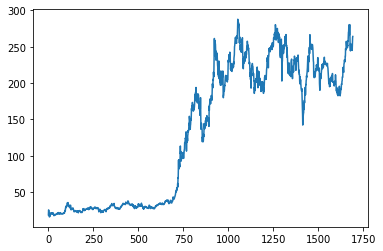

In [17]:
Tesla["Open"].plot()

In [19]:
Tesla.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

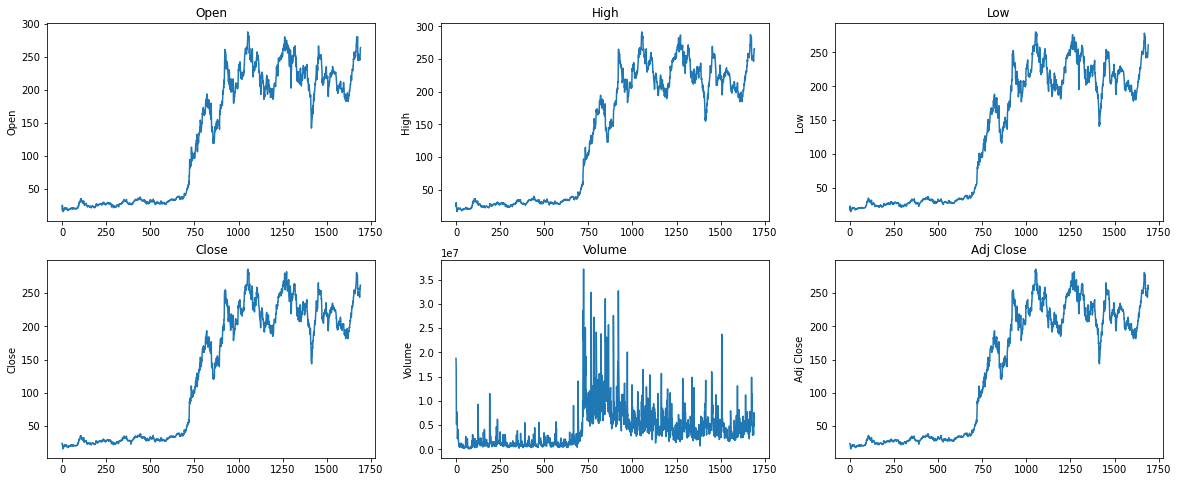

In [20]:
col_names = ['Open', 'High', 'Low', 'Close','Volume','Adj Close']
plt.figure(figsize=(20,8))
for i, name in enumerate(col_names):
    plt.subplot(2, 3, i+1)
    plt.plot(Tesla[name])
    plt.title(name)
    plt.ylabel(name)

# Scaling Data

In [21]:
cols = ["Open", "High", "Low", "Close", "Volume"]

scaler = MinMaxScaler()
df = scaler.fit_transform(Tesla[cols])
df = pd.DataFrame(columns = cols, data = df)
df.head()

,Open,High,Low,Close,Volume
0,0.010533,0.030460,0.009645,0.029936,0.503377
1,0.035539,0.050184,0.031347,0.029714,0.460748
2,0.032630,0.033808,0.019931,0.022795,0.218659
3,0.025264,0.023545,0.014053,0.012581,0.135544
4,0.014216,0.012264,0.003202,0.001147,0.182166


In [22]:
print(df.shape)

xtrain, ytrain = df.iloc[0:1000, [0,1,2,4] ].to_numpy(), df.iloc[0:1000, 3].to_numpy()
xtest, ytest = df.iloc[1000:, [0,1,2,4] ].to_numpy(), df.iloc[1000:, 3].to_numpy()

(1692, 5)


In [23]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(1000, 4)
(1000,)
(692, 4)
(692,)


### Custom LSTM cell class and activation function:

In [25]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [26]:
class LSTM:
    def __init__(self, unit_size , input_size):
        self.unit_size = unit_size
        self.input_size = input_size

        # initialize dict of parameters:
        self.weights = {}

        # initialize empty dicts for each output of the LSTM gates, since we will need each of them to perform backpropagation:
        self.f, self.i, self.a, self.o, self.h, self.c = {}, {}, {}, {}, {}, {}

        # initalize empty dicts for the gradients of each of the outputs:
        self.df, self.di, self.da, self.do, self.dh, self.dc = {}, {}, {}, {}, {}, {}

        # initialize loss gradient, and gradient coming from (t+1)th cell into h_t and c_t, respectively:
        self.dloss, self.dh_diff, self.dc_diff = {}, {}, {}

        # test random initialization of weight vectors to test


        # forget gate:
        self.weights["Wf"] = np.random.rand(self.input_size)
        self.weights["Uf"] = np.random.rand(self.unit_size)
        self.weights["bf"] = np.ones(self.unit_size)
#         self.weights["Wf"] = np.array([0.7, 0.45])
#         self.weights["Uf"] = np.array([0.1])
#         self.weights["bf"] = np.array([0.15])

        # input gate:
        self.weights["Wi"] = np.random.rand(self.input_size)
        self.weights["Ui"] = np.random.rand(self.unit_size)
        self.weights["bi"] = np.ones(self.unit_size)
#         self.weights["Wi"] = np.array([0.95, 0.8])
#         self.weights["Ui"] = np.array([0.8])
#         self.weights["bi"] = np.array([0.65])

        # activation gate (if not part of input gate):
        self.weights["Wa"] = np.random.rand(self.input_size)
        self.weights["Ua"] = np.random.rand(self.unit_size)
        self.weights["ba"] = np.ones(self.unit_size)
#         self.weights["Wa"] = np.array([0.45, 0.25])
#         self.weights["Ua"] = np.array([0.15])
#         self.weights["ba"] = np.array([0.2])

        # output gate:
        self.weights["Wo"] = np.random.rand(self.input_size)
        self.weights["Uo"] = np.random.rand(self.unit_size)
        self.weights["bo"] = np.ones(self.unit_size)
#         self.weights["Wo"] = np.array([0.6, 0.4])
#         self.weights["Uo"] = np.array([0.25])
#         self.weights["bo"] = np.array([0.1])


    def forward(self, x_t, h_prev, c_prev):
        # x_t is the current sample being passed through the LSTM
        # h_prev is the previous hidden state from the last timestep
        # c_prev is the previous cell state from the last timestep

        # forget gate:
        f_t = sigmoid(np.dot(self.weights["Wf"], x_t) + np.dot(self.weights["Uf"], h_prev) + self.weights["bf"])

        # input gate:
        i_t = sigmoid(np.dot(self.weights["Wi"], x_t) + np.dot(self.weights["Ui"], h_prev) + self.weights["bi"])
        a_t = np.tanh( np.dot(self.weights["Wa"], x_t) + np.dot(self.weights["Ua"], h_prev) + self.weights["ba"] )

        # output gate:
        o_t = sigmoid(np.dot(self.weights["Wo"], x_t) + np.dot(self.weights["Uo"], h_prev) + self.weights["bo"])

        c_t = f_t * c_prev + i_t * a_t
        h_t = o_t * np.tanh(c_t)

        # print("forget ", f_t)
        # print("input ", i_t)
        # print("activation ", a_t)
        # print("output ", o_t)

        # print("cell state ", c_t)
        # print("hidden state ", h_t)
        # print()
        # print()

        # need to return all the parameters calculated, since they will be used during backpropagation:
        return f_t, i_t, a_t, o_t, h_t, c_t


    
    def backward(self, timesteps, X, y, lr):
        # calculate gradients for all timesteps:
        for t in reversed(range(timesteps)):
            # difference between predicted and actual. our loss function is square error E(yhat) = 0.5(y - yhat)**2,
            # so dE(yhat) = y - yhat = dloss[t]
            self.dloss[t] = self.h[t] - y[t]
            
            self.dh[t] = self.dloss[t] + self.dh_diff[t + 1] # hidden state grad
            self.dc[t] = self.dh[t] * ( 1 - np.tanh(self.c[t])**2 ) * self.o[t] + self.dc[t + 1] * self.f[t + 1] # cell state grad

            # gates
            self.do[t] = self.dh[t] * np.tanh(self.c[t]) * self.o[t] * (1 - self.o[t])
            self.da[t] = self.dc[t] * self.i[t] * (1 - self.a[t]**2)
            self.di[t] = self.dc[t] * self.a[t] * self.i[t] * (1 - self.i[t])
            self.df[t] = self.dc[t] * self.c[t - 1] * self.f[t] * (1 - self.f[t])

            U = np.array( (self.weights["Uo"], self.weights["Ua"], self.weights["Ui"], self.weights["Uf"]) ).reshape(1,-1)
            dgates = np.array([self.do[t], self.da[t], self.di[t], self.df[t]]).reshape(-1,1)
            # print(U)
            # print(dgates)
            self.dh_diff[t] = np.dot(U, dgates)

            # print("dh",self.dh[t])
            # print("dc", self.dc[t])
            # print()
            # print("do", self.do[t])
            # print("da", self.da[t])
            # print("di", self.di[t])
            # print("df", self.df[t])
            # print()
            # print("d out", self.dh_diff[t])
            # print()
            # print()
            # print()

        # update weights for all W and U matrices (stochastic gradient descent => W_new = W_old - l*dW, l = learning rate):
        # dW = np.zeros_like()
        for t in range(timesteps):
            self.weights["Wf"] = self.weights["Wf"] - lr * np.array([ self.df[t]*X[t][i] for i in range(len(X[t])) ]).reshape(1,-1)
            self.weights["Wi"] = self.weights["Wi"] - lr * np.array([ self.di[t]*X[t][i] for i in range(len(X[t])) ]).reshape(1,-1)
            self.weights["Wa"] = self.weights["Wa"] - lr * np.array([ self.da[t]*X[t][i] for i in range(len(X[t])) ]).reshape(1,-1)
            self.weights["Wo"] = self.weights["Wo"] - lr * np.array([ self.do[t]*X[t][i] for i in range(len(X[t])) ]).reshape(1,-1)

            if t != timesteps - 1:
                self.weights["Uf"] = self.weights["Uf"] - lr * self.df[t + 1] * self.h[t]
                self.weights["Ui"] = self.weights["Ui"] - lr * self.di[t + 1] * self.h[t]
                self.weights["Ua"] = self.weights["Ua"] - lr * self.da[t + 1] * self.h[t]
                self.weights["Uo"] = self.weights["Uo"] - lr * self.do[t + 1] * self.h[t]

            self.weights["bf"] = self.weights["bf"] - lr * self.df[t]
            self.weights["bi"] = self.weights["bi"] - lr * self.di[t]
            self.weights["ba"] = self.weights["ba"] - lr * self.da[t]
            self.weights["bo"] = self.weights["bo"] - lr * self.do[t]

            # dgates = np.array([self.do[t], self.da[t], self.di[t], self.df[t]]).reshape(-1,1)
            # xt = X[t].reshape(1,-1)
            # dW += np.dot(dgates, xt)

    
    
    
    def train(self, X, y, lr = 0.1, bs = 4, epochs = 50):
        # learning rate = lr
        # batch size = 8
        assert len(X) == len(y), "Length of train samples doesn't match length labels"
        
        # batch the data
        xbatches, ybatches = self.get_batches(X, y, bs)
        assert len(xbatches) == len(ybatches), "Something went wrong with batching"
        
        for e in range(epochs):
        
            for i in range(len(xbatches)):

                self.reset_params_grads() # reinitialize all parameters dicts to be empty

                # initialize a hidden and cell state at time t = -1 (before training starts)
                self.h[-1], self.c[-1] = 0, 0 

    #             timesteps = len(X)
                for t in range(bs):
                    self.f[t], self.i[t], self.a[t], self.o[t], self.h[t], self.c[t] = self.forward(xbatches[i][t], self.h[t-1], self.c[t-1])

                # create empty t + 1 states which are referenced for backpropagation:
                # at the end of the above loop, the variable 'timesteps' is already equal to t + 1
                self.h[bs], self.c[bs] = 0, 0
                self.dh_diff[bs] = 0
                self.dc[bs] = 0
                self.f[bs] = 0

                # backpropagate and update weights:
                self.backward(bs, xbatches[i], ybatches[i], lr)
        
    
    
    
    def predict(self, X):
        preds = []
        self.reset_params_grads()
        self.h[-1], self.c[-1] = 0, 0 
        for t in range(len(X)):
            self.f[t], self.i[t], self.a[t], self.o[t], self.h[t], self.c[t] = self.forward(X[t], self.h[t-1], self.c[t-1])
            preds.append(float(self.h[t][0]))
        return preds
    
    
    
    def get_batches(self, X, y, bs):
        xbatches, ybatches = [], []
        tempx, tempy = [], []
        for i in range(len(X)):
            
            tempx.append(X[i])
            tempy.append(y[i])
            
            if len(tempx) == bs or i == len(X) - 1:
                xbatches.append(np.array(tempx))
                ybatches.append(np.array(tempy))
                tempx, tempy = [], []
                
        return xbatches, ybatches
            
    
    
    
    def reset_params_grads(self):
        # resets all parameter and gradient dictionaries to empty/zero 
        self.f, self.i, self.a, self.o, self.h, self.c = {}, {}, {}, {}, {}, {}
        self.df, self.di, self.da, self.do, self.dh, self.dc = {}, {}, {}, {}, {}, {}
        self.dh_diff = {}

    
    
    
    
    def __str__(self):
        for key in self.weights.keys():
            print(key, " ", self.weights[key])

        return ""



In [27]:
np.random.seed(0)
model = LSTM(unit_size = 1, input_size = 4)
print(model)

Wf   [0.5488135  0.71518937 0.60276338 0.54488318]
Uf   [0.4236548]
bf   [1.]
Wi   [0.64589411 0.43758721 0.891773   0.96366276]
Ui   [0.38344152]
bi   [1.]
Wa   [0.79172504 0.52889492 0.56804456 0.92559664]
Ua   [0.07103606]
ba   [1.]
Wo   [0.0871293  0.0202184  0.83261985 0.77815675]
Uo   [0.87001215]
bo   [1.]



In [28]:
model.train(xtrain, ytrain, 0.1, 8, epochs = 20)
print(model)

Wf   [[0.38037142 0.5454912  0.43926291 0.34605705]]
Uf   [[0.08270311]]
bf   [[0.32860123]]
Wi   [[0.76008348 0.55172856 1.00717117 0.95412365]]
Ui   [[0.27751804]]
bi   [[0.89445369]]
Wa   [[ 0.76346281  0.49781785  0.58842476 -0.06067304]]
Ua   [[-1.53356532]]
ba   [[0.04178007]]
Wo   [[0.44823233 0.38337168 1.20627482 0.59825273]]
Uo   [[0.17710633]]
bo   [[0.55268801]]



In [29]:
preds_test = model.predict(xtest)

In [30]:
preds_train = model.predict(xtrain)

In [31]:
preds_df_test = pd.DataFrame(list(zip(ytest, preds_test)), columns = ["Actual", "Predicted"])
preds_df_test.head(10)

,Actual,Predicted
0,0.784451,0.633084
1,0.791112,0.748415
2,0.819346,0.788543
3,0.801880,0.812269
4,0.818125,0.811881
5,0.813351,0.820675
6,0.826154,0.823684
7,0.829855,0.832254
8,0.828597,0.836450
9,0.790519,0.834082


<AxesSubplot:>

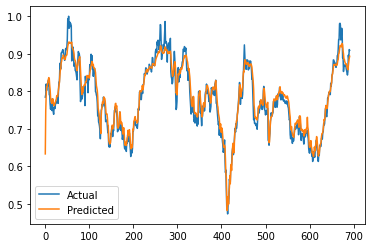

In [32]:
preds_df_test.plot()

In [33]:
preds_df_train = pd.DataFrame(list(zip(ytrain, preds_train)), columns = ["Actual", "Predicted"])
preds_df_train.head(10)

,Actual,Predicted
0,0.029936,0.022781
1,0.029714,0.042839
2,0.022795,0.033309
3,0.012581,0.030327
4,0.001147,0.019775
5,0.000000,0.012265
6,0.006143,0.014087
7,0.005921,0.019470
8,0.004626,0.021047
9,0.008659,0.020327


<AxesSubplot:>

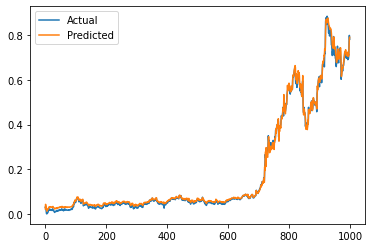

In [34]:
preds_df_train.plot()

In [35]:
# Train MSE

np.square(np.subtract(ytrain,preds_train)).mean()

0.00013276684045493873

In [36]:
# Test MSE

np.square(np.subtract(ytest,preds_test)).mean()

0.0004850970628304501

Text(0.5, 1.0, 'Validation test MSE loss')

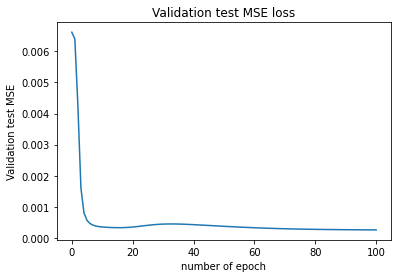

In [47]:


error = []
epoche = list(range(101))
for i in epoche:
    model.train(xtrain, ytrain, 0.1, 8, epochs = i)
    y_hat = model.predict(xtest)
    error.append(np.square(np.subtract(ytest, y_hat)).mean())

plt.plot(epoche, error)
plt.xlabel("number of epoch")
plt.ylabel("Validation test MSE")
plt.title("Validation test MSE loss")
        





Text(0.5, 1.0, 'Training MSE loss')

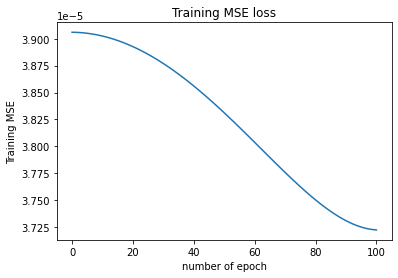

In [49]:
error1 = []
epoche1 = list(range(101))
for i in epoche1:
    model.train(xtrain, ytrain, 0.1, 8, epochs = i)
    y_hat1 = model.predict(xtrain)
    error1.append(np.square(np.subtract(ytrain, y_hat1)).mean())

plt.plot(epoche1, error1)
plt.xlabel("number of epoch")
plt.ylabel("Training MSE")
plt.title("Training MSE loss")